# Imports

In [1]:



import pandas as pd
import numpy as np
import jsonlines
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch_optimizer as optim
import random
from transformers import AutoModelWithLMHead, AutoTokenizer, AutoModel

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from importlib import reload
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:0.3f}'.format)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.width = 0
import warnings
import torchvision
warnings.filterwarnings('ignore')

from facebook_hateful_memes_detector.utils.globals import set_global, get_global
set_global("cache_dir", "/home/ahemf/cache/cache")
set_global("dataloader_workers", 4)
set_global("use_autocast", True)
set_global("models_dir", "/home/ahemf/cache/")

from facebook_hateful_memes_detector.utils import read_json_lines_into_df, in_notebook, set_device, random_word_mask, my_collate
get_global("cache_dir")
from facebook_hateful_memes_detector.models import MultiImageMultiTextAttentionEarlyFusionModel, LangFeaturesModel, AlbertClassifer
from facebook_hateful_memes_detector.preprocessing import TextImageDataset, get_datasets, get_image2torchvision_transforms, TextAugment
from facebook_hateful_memes_detector.preprocessing import DefinedRotation, QuadrantCut, ImageAugment
from facebook_hateful_memes_detector.training import *
import facebook_hateful_memes_detector
reload(facebook_hateful_memes_detector)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_device(device)


In [2]:
# data = get_datasets(data_dir="../data/", train_text_transform=None, train_image_transform=None, 
#                     test_text_transform=None, test_image_transform=None, 
#                     cache_images = True, use_images = False, dev=False, test_dev=True,
#                     keep_original_text=False, keep_original_image=False, 
#                     keep_processed_image=True, keep_torchvision_image=False,)

# texts = list(data["train"].text.values) + list(data["test"].text.values) + list(data["dev"].text.values)
# pd.DataFrame({"texts": texts}).to_csv("text.csv", header=False, index=False)


In [3]:
initial_model = "/home/ahemf/cache/distilbert-mlm"
model_type = "distilroberta-base"
output_model = "/home/ahemf/cache/distilbert-v2"
batch_size = 256

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
tokenizer.vocab_size

tokenizer = AutoTokenizer.from_pretrained(model_type)
tokenizer.vocab_size
tokenizer.sep_token
tokenizer.sep_token_id
tokenizer.special_tokens_map




texts = pd.read_csv("text.csv", header=None)[0].values

def save(model, tokenizer, output_dir):
    import os
    os.makedirs(output_dir, exist_ok=True)
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)

scheduler_init_fn = get_cosine_schedule_with_warmup()


30522

50265

'</s>'

2

{'bos_token': '<s>',
 'eos_token': '</s>',
 'unk_token': '<unk>',
 'sep_token': '</s>',
 'pad_token': '<pad>',
 'cls_token': '<s>',
 'mask_token': '<mask>'}

https://discuss.pytorch.org/t/how-to-implement-torch-optim-lr-scheduler-cosineannealinglr/28797/11

# Augmented/Masked Text same as Original Text - RMSE

Autocast =  True Epochs =  10 Examples = 10000 Batch Size =  128
Training Samples =  10000 Weighted Sampling =  False Num Batches =  79 Accumulation steps =  2
[WARN]: Number of training batches not divisible by accumulation steps, some training batches will be wasted due to this.



Epoch =  1 Loss = 0.033178 LR = 0.00000333



Epoch =  2 Loss = 0.027472 LR = 0.00000667



Epoch =  3 Loss = 0.025090 LR = 0.00001000


Exception for:  keyboard | '' '' | ['one_third_cut' 'keyboard'] argument of type 'NoneType' is not iterable

Epoch =  4 Loss = 0.023785 LR = 0.00000950



Epoch =  5 Loss = 0.023296 LR = 0.00000812



Epoch =  6 Loss = 0.022819 LR = 0.00000611



Epoch =  7 Loss = 0.022657 LR = 0.00000389



Epoch =  8 Loss = 0.022411 LR = 0.00000188



Epoch =  9 Loss = 0.022420 LR = 0.00000050



Epoch =  10 Loss = 0.022393 LR = 0.00000000



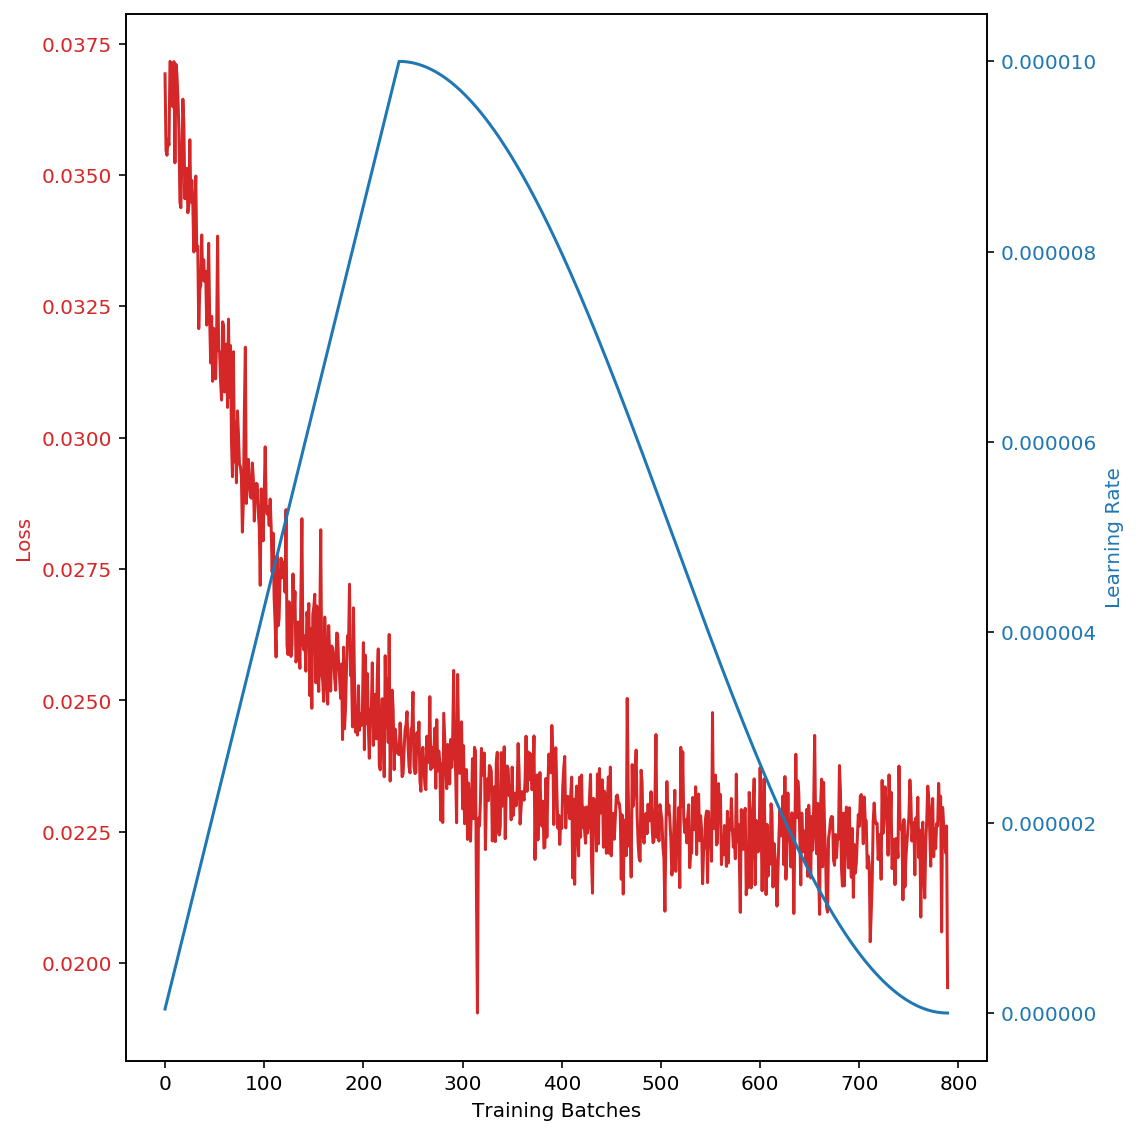

In [9]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=1e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer = adamw
optimizer_params = adamw_params

from transformers import AutoModelWithLMHead, AutoTokenizer, AutoModel


class BertVectorizer(torch.nn.Module):
    def __init__(self, model, sequence_length, pooled_multiplier):
        super().__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(model)
        self.model = AutoModel.from_pretrained(model)
        self.sequence_length = sequence_length
        self.pooled_multiplier = pooled_multiplier

    def forward(self, texts):
        tokenizer = self.tokenizer
        n_tokens_in = self.sequence_length
        converted_texts = tokenizer.batch_encode_plus(texts,
                                                      add_special_tokens=True,
                                                      pad_to_max_length=True,
                                                      max_length=n_tokens_in,
                                                      truncation=True)
        input_ids, attention_mask = converted_texts[
            "input_ids"], converted_texts["attention_mask"]
        input_ids, attention_mask = torch.tensor(input_ids).to(
            get_device()), torch.tensor(attention_mask).to(get_device())
        outputs = self.model(input_ids, attention_mask=attention_mask)
        last_hidden_states = outputs[0]
        pooled_output = outputs[1].unsqueeze(1)
        pooled_output = pooled_output * self.pooled_multiplier
        output = torch.cat((pooled_output, last_hidden_states), 1)
        return output


from torchtext.data import Dataset, TabularDataset, Field
dataset = Dataset(texts, [("text", Field())])

epochs = 10
batch_size = 128
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "finetune": True
        },
    }
}

model_fn = model_builder(
    BertVectorizer,
    dict(sequence_length=96, pooled_multiplier=4,
         model=initial_model),  # initial_model
    per_param_opts_fn=lr_strategy,
    optimiser_class=optimizer,
    optimiser_params=optimizer_params)

model, optim = model_fn()

choice_probas = {
    "keyboard": 0.1,
    "char_substitute": 0.0,
    "char_insert": 0.1,
    "char_swap": 0.1,
    "ocr": 0.0,
    "char_delete": 0.1,
    "fasttext": 0.0,
    "glove_twitter": 0.0,
    "glove_wiki": 0.0,
    "word2vec": 0.0,
    "split": 0.1,
    "stopword_insert": 0.3,
    "word_join": 0.1,
    "word_cutout": 0.8,
    "text_rotate": 0.0,
    "sentence_shuffle": 0.0,
    "one_third_cut": 0.3,
    "part_select": 0.5,
    "half_cut": 0.2
}

preprocess_text = TextAugment([0.0, 0.5, 0.5],
                              choice_probas,
                              fasttext_file="wiki-news-300d-1M-subword.bin")

vectorized_text_processor = np.vectorize(preprocess_text)


def augment_method(texts):
    mask_proba = 0.15
    texts = [random_word_mask(t, model.tokenizer, mask_proba) for t in texts]
    return vectorized_text_processor(texts)


_ = train_for_augment_similarity(model,
                                 optim,
                                 scheduler_init_fn,
                                 batch_size,
                                 epochs,
                                 dataset,
                                 augment_method=augment_method,
                                 model_call_back=None,
                                 accumulation_steps=2,
                                 plot=True)

# 0.06687

save(model.model, model.tokenizer, output_dir=output_model + "-augsim")


# Coherence [Not useful]
- Two halves belong to same sentence 
- Is first half swapped with 2nd half

Pick stored Model /home/ahemf/cache/distilbert-v2-augsim Model Class =  <class 'transformers.modeling_roberta.RobertaModel'> Tokenizer Class =  <class 'transformers.tokenization_roberta.RobertaTokenizer'>
Autocast =  True Epochs =  20 Divisor = 1 Examples = 10000 Batch Size =  256
Training Samples =  10000 Weighted Sampling =  False Num Batches =  40 Accumulation steps =  1



Epoch =  1 Loss = 1.578694 LR = 0.00016667



Epoch =  2 Loss = 1.393574 LR = 0.00033333



Epoch =  3 Loss = 1.311576 LR = 0.00050000



Epoch =  4 Loss = 1.277452 LR = 0.00066667



Epoch =  5 Loss = 1.276755 LR = 0.00083333



Epoch =  6 Loss = 1.245540 LR = 0.00100000



Epoch =  7 Loss = 1.244774 LR = 0.00098746



Epoch =  8 Loss = 1.222204 LR = 0.00095048



Epoch =  9 Loss = 1.208574 LR = 0.00089092



Epoch =  10 Loss = 1.209047 LR = 0.00081174



Epoch =  11 Loss = 1.242631 LR = 0.00071694



Epoch =  12 Loss = 1.166780 LR = 0.00061126



Epoch =  13 Loss = 1.154312 LR = 0.00050000



Epoch =  14 Loss = 1.157773 LR = 0.00038874



Epoch =  15 Loss = 1.147917 LR = 0.00028306



Epoch =  16 Loss = 1.123734 LR = 0.00018826



Epoch =  17 Loss = 1.094427 LR = 0.00010908



Epoch =  18 Loss = 1.112512 LR = 0.00004952



Epoch =  19 Loss = 1.101382 LR = 0.00001254



Epoch =  20 Loss = 1.109257 LR = 0.00000000



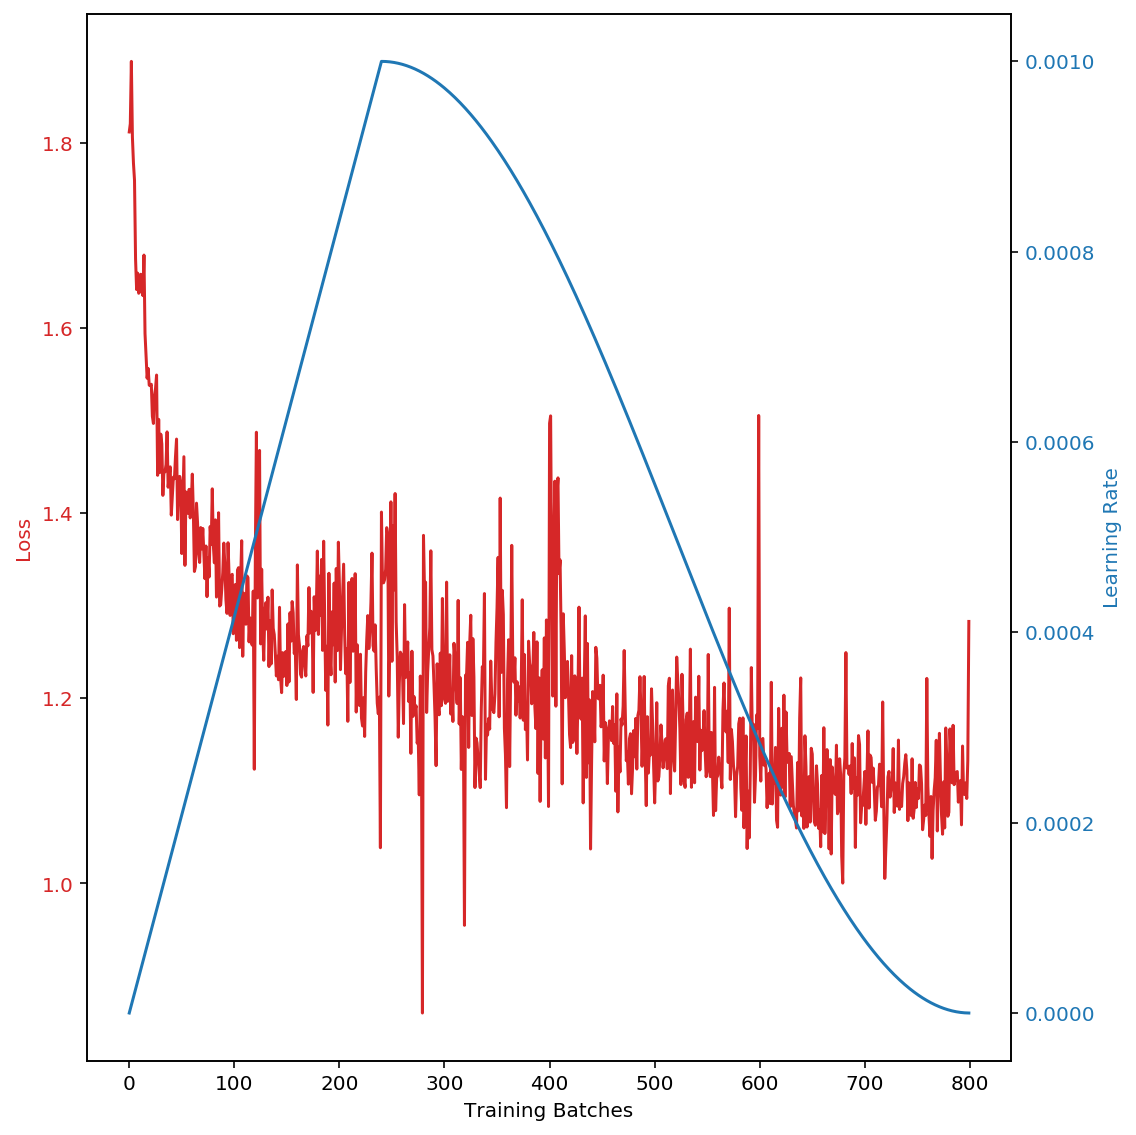

([0, 0.5253, 0],
 (array([0.59804321, 0.39083652]),
  array([0.59779951, 0.43898635]),
  array([0.59792134, 0.41351451]),
  array([2454, 2565])))

Autocast =  True Epochs =  10 Divisor = 1 Examples = 10000 Batch Size =  128
Training Samples =  10000 Weighted Sampling =  False Num Batches =  79 Accumulation steps =  2
[WARN]: Number of training batches not divisible by accumulation steps, some training batches will be wasted due to this.



Epoch =  1 Loss = 1.094085 LR = 0.00003333



Epoch =  2 Loss = 1.067726 LR = 0.00006667



Epoch =  3 Loss = 0.993213 LR = 0.00010000



Epoch =  4 Loss = 0.926167 LR = 0.00009505



Epoch =  5 Loss = 0.838520 LR = 0.00008117



Epoch =  6 Loss = 0.795971 LR = 0.00006113



Epoch =  7 Loss = 0.778026 LR = 0.00003887



Epoch =  8 Loss = 0.724482 LR = 0.00001883



Epoch =  9 Loss = 0.692848 LR = 0.00000495



Epoch =  10 Loss = 0.682994 LR = 0.00000000



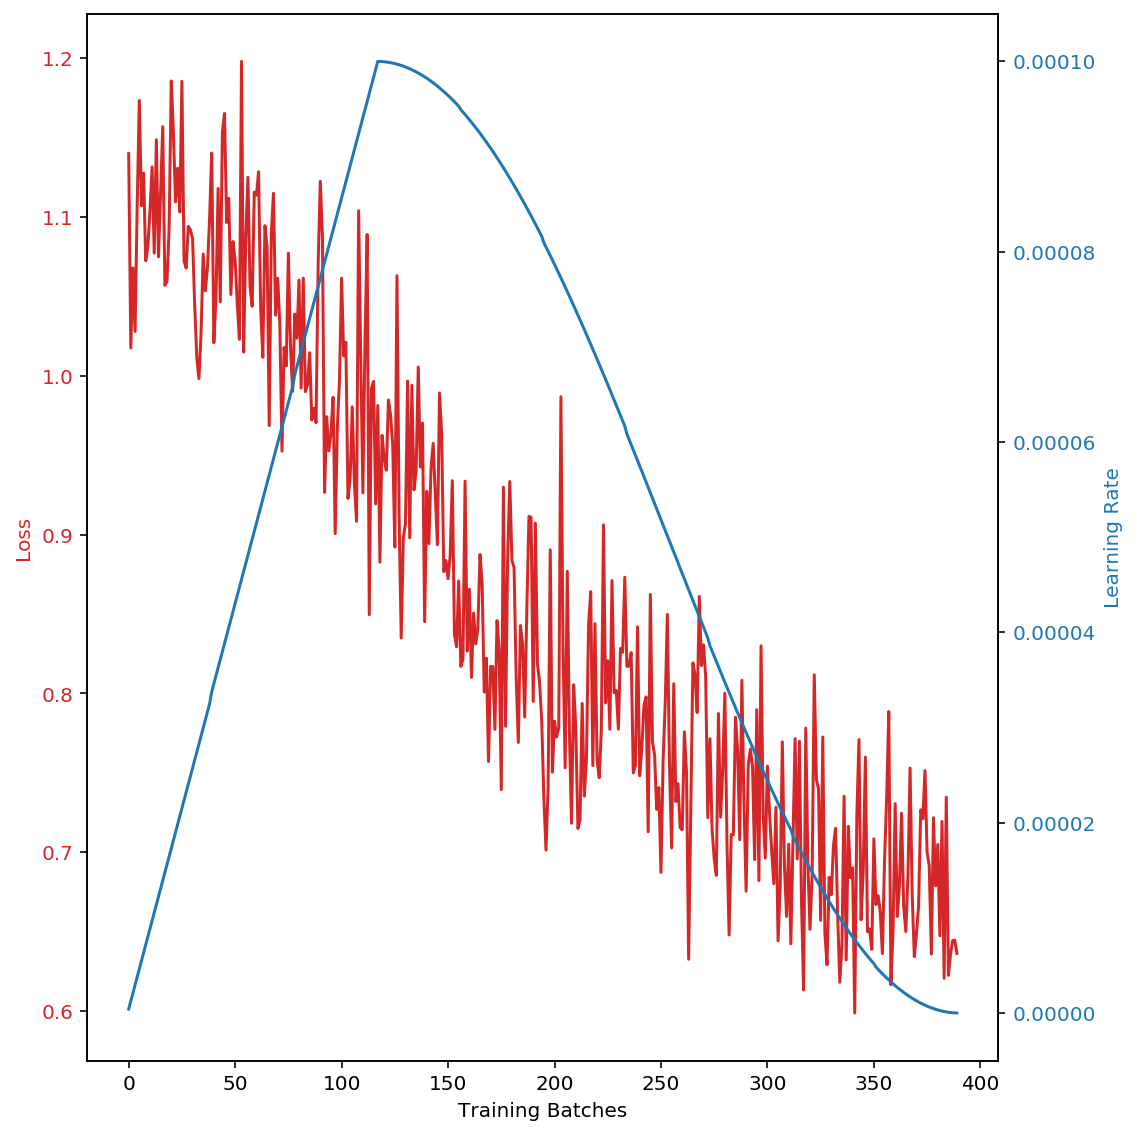

Proba       Preds    
         min   max   min max
Labels                      
0      0.000 0.540     0   4
1      0.001 0.655     0   4
2      0.003 0.707     0   4
3      0.000 0.570     0   4
4      0.000 0.437     0   4

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.406,"[0.001201910781674087, 0.40625783801078796, 0....",2,2,0.461,"[0.011661166325211525, 0.46103963255882263, 0....",2,2,0.033,"[0.803480327129364, 0.03336883708834648, 0.037...",0,0
1,0.006,"[0.8944968581199646, 0.005710032302886248, 0.0...",0,0,0.447,"[0.03380044922232628, 0.44709092378616333, 0.5...",2,2,0.001,"[0.046132102608680725, 0.0011995878303423524, ...",3,3
2,0.365,"[0.20893433690071106, 0.36460423469543457, 0.4...",2,2,0.152,"[0.6112920045852661, 0.15201511979103088, 0.21...",0,0,0.013,"[0.6408522725105286, 0.013358808122575283, 0.0...",0,3
3,0.505,"[0.02122502215206623, 0.5048382878303528, 0.47...",1,1,0.053,"[0.8834323287010193, 0.05278698354959488, 0.04...",0,0,0.494,"[0.03542308136820793, 0.4941992163658142, 0.46...",1,1
4,0.429,"[0.05107463151216507, 0.4291103780269623, 0.50...",2,1,0.420,"[0.1195245236158371, 0.42000532150268555, 0.44...",2,2,0.010,"[0.9715288877487183, 0.009788603521883488, 0.0...",0,0


scores =  {'map': '0.0000', 'acc': '0.6637', 'auc': '0.0000'}


([0, 0.6637, 0],
 (array([0.8304815 , 0.46478873]),
  array([0.86525705, 0.39130435]),
  array([0.84751269, 0.4248927 ]),
  array([2412, 2530])))

In [10]:
from torch.utils.data import Dataset, DataLoader
from mmf.common.sample import Sample, SampleList
import random


choice_probas = {
    "keyboard": 0.0,
    "char_substitute": 0.0,
    "char_insert": 0.1,
    "char_swap": 0.0,
    "ocr": 0.0,
    "char_delete": 0.1,
    "split": 0.2,
    "stopword_insert": 0.2,
    "word_join": 0.2,
    "word_cutout": 0.5,
    "text_rotate": 0.0,
    "sentence_shuffle": 0.2,
    "one_third_cut": 0.0,
    "half_cut": 0.0,
    "part_select": 0.5
}

preprocess_text = TextAugment([0.0, 1.0],
                                choice_probas,
                                fasttext_file="wiki-news-300d-1M-subword.bin")

def split(text):
    parts = text.split()
    half = len(parts) // 2
    return " ".join(parts[:half]), " ".join(parts[half:])
class CoherenceDataset(Dataset):
    def __init__(self, texts, preprocess_text, separator_token):
        self.texts = list(texts)
        self.sep = separator_token
        self.preprocess_text = preprocess_text
        
    def __getitem__(self, item):
        org_text = self.texts[item]
        text = self.preprocess_text(org_text)
        text_part_1, text_part_2 = split(text)
        if random.random() < 0.5:
            if random.random() < 0.5:
                return Sample({"text": self.__build_split__(text_part_1, text_part_2), "label": 1})
            else:
                return Sample({"text": self.__build_split__(text_part_2, text_part_1), "label": 0})
        else:
            text2 = self.preprocess_text(random.sample(self.texts, 1)[0])
            text2_part_1, text2_part_2 = split(text)
            if random.random() < 0.5:
                if random.random() < 0.5:
                    return Sample({"text": self.__build_split__(text_part_1, text2_part_2), "label": 2})
                else:
                    return Sample({"text": self.__build_split__(text2_part_1, text_part_2), "label": 2})
            else:
                if random.random() < 0.8:
                    return Sample({"text": self.__build_split__(text, text2), "label": 3})
                else:
                    if random.random() < 0.5:
                        return Sample({"text": self.__build_split__(org_text, text), "label": 4})
                    else:
                        return Sample({"text": self.__build_split__(text, org_text), "label": 4})
    
    def __build_split__(self, text_part_1, text_part_2):
        if random.random() < 0.5:
            return text_part_1 + self.sep + text_part_2
        else:
            return text_part_1 + text_part_2
            
    def __len__(self):
        return len(self.texts)
          
    
model_name = initial_model # output_model + "-mlm"

optimizer_class = torch.optim.AdamW
optimizer_params = dict(lr=1e-3, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-2)

dataset = CoherenceDataset(texts, preprocess_text, f" {tokenizer.sep_token} ")

epochs = 20
batch_size=256
lr_strategy = {
    "model": {
        "finetune": False,
    }
}

model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=5,
                              gaussian_noise=0.0,
                              dropout=0.0,
                              word_masking_proba=0.0,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=0,
                              n_encoders=0,
                              n_decoders=0,
                              n_tokens_in=96 * 2,
                              n_tokens_out=48,
                              featurizer="transformer",
                              classification_head="head_ensemble",
                              model=output_model + "-augsim",
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer_class,
                         optimiser_params=optimizer_params)


model, optimizer = model_fn()
train_losses, learning_rates = train(model, optimizer, scheduler_init_fn, batch_size, epochs, dataset,
                                     model_call_back=None, accumulation_steps=1, plot=True,
                                     sampling_policy=None, class_weights=None)

validate(model, batch_size, dataset, display_detail=False)

###

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "finetune": True,
            "lr": optimizer_params["lr"] / 10,
        },
    },
    "final_layer": {
        "lr": optimizer_params["lr"],
    }
}
epochs = 10
batch_size=128
optimizer_class = torch.optim.AdamW
optimizer_params = dict(lr=1e-4, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-4)

_ = group_wise_finetune(model, lr_strategy)
params_conf, _ = group_wise_lr(model, lr_strategy)
optimizer = optimizer_class(params_conf, **optimizer_params)

train_losses, learning_rates = train(model, optimizer, scheduler_init_fn, batch_size, epochs, dataset,
                                     model_call_back=None, accumulation_steps=2, plot=True,
                                     sampling_policy=None, class_weights=None)

validate(model, batch_size, dataset, display_detail=True)

save(model.model, model.tokenizer, output_dir=output_model + "-cor")


# NSP Dual Model

- This task hasn't shown usefulness

15000 30000
Autocast =  True Epochs =  20 Divisor = 1 Examples = 30000 Batch Size =  128
Training Samples =  30000 Weighted Sampling =  False Num Batches =  235 Accumulation steps =  2
[WARN]: Number of training batches not divisible by accumulation steps, some training batches will be wasted due to this.



Epoch =  1 Loss = 0.655083 LR = 0.00001667



Epoch =  2 Loss = 0.637725 LR = 0.00003333



Epoch =  3 Loss = 0.637223 LR = 0.00005000



Epoch =  4 Loss = 0.637765 LR = 0.00006667



Epoch =  5 Loss = 0.638091 LR = 0.00008333



Epoch =  6 Loss = 0.637776 LR = 0.00010000



Epoch =  7 Loss = 0.638373 LR = 0.00009875



Epoch =  8 Loss = 0.638070 LR = 0.00009505



Epoch =  9 Loss = 0.637285 LR = 0.00008909



Epoch =  10 Loss = 0.637315 LR = 0.00008117



Epoch =  11 Loss = 0.636835 LR = 0.00007169



Epoch =  12 Loss = 0.636562 LR = 0.00006113



Epoch =  13 Loss = 0.635747 LR = 0.00005000



Epoch =  14 Loss = 0.635347 LR = 0.00003887



Epoch =  15 Loss = 0.635151 LR = 0.00002831



Epoch =  16 Loss = 0.634540 LR = 0.00001883



Epoch =  17 Loss = 0.634215 LR = 0.00001091



Epoch =  18 Loss = 0.634188 LR = 0.00000495



Epoch =  19 Loss = 0.633670 LR = 0.00000125



Epoch =  20 Loss = 0.634234 LR = 0.00000000



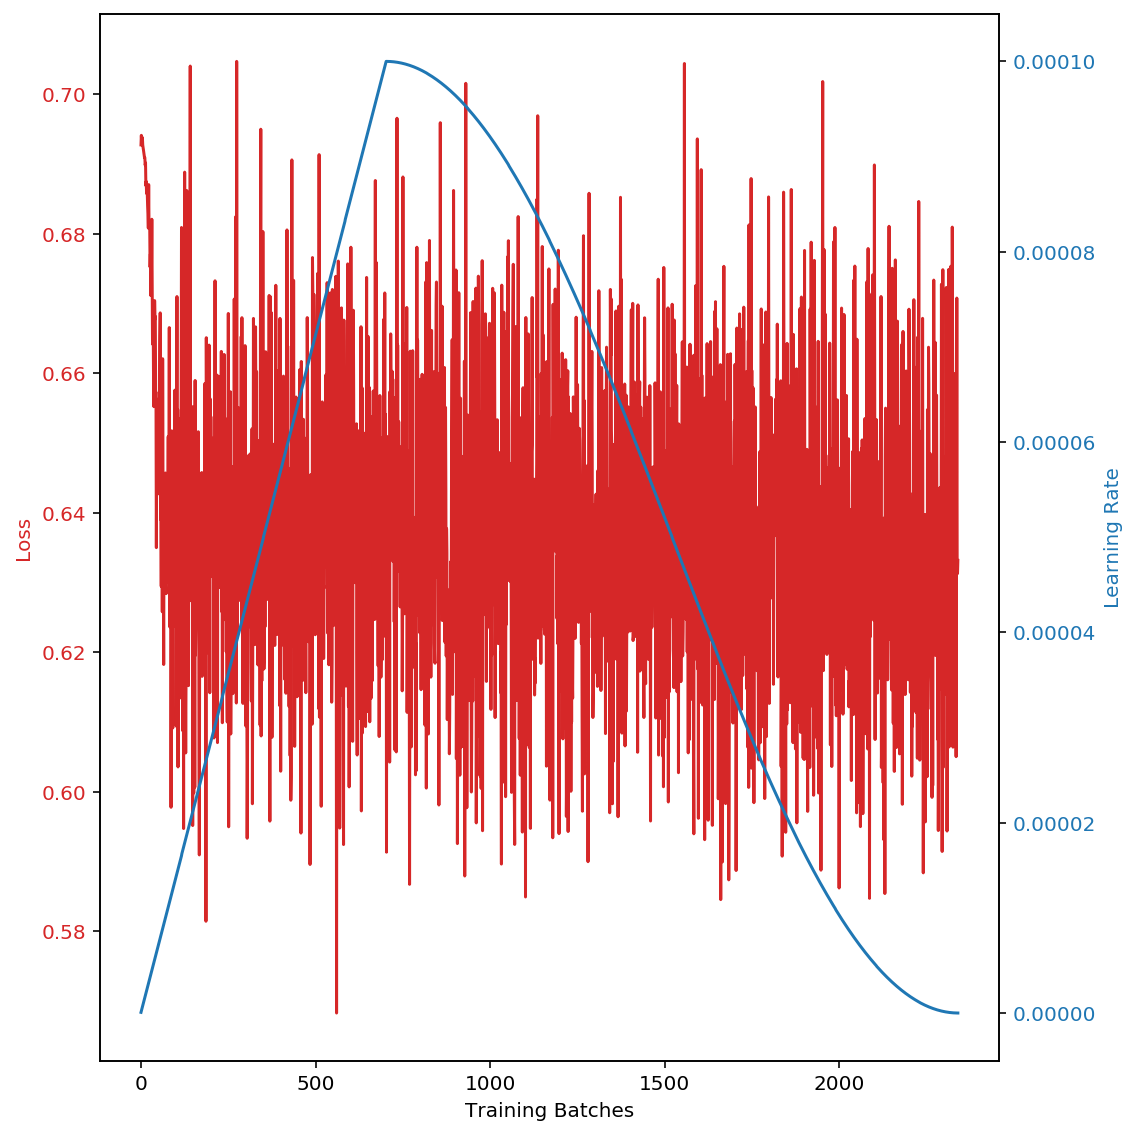

Proba        Preds    
          min    max   min max
Labels                        
0      -0.338 -0.242     0   0
1      -0.324 -0.227     0   0

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,-0.293,"[0.400634765625, -0.293212890625]",0,1,-0.280,"[0.3779296875, -0.2802734375]",0,0,-0.294,"[0.407470703125, -0.293701171875]",0,0
1,-0.283,"[0.383544921875, -0.283203125]",0,0,-0.292,"[0.3828125, -0.29248046875]",0,1,-0.316,"[0.42333984375, -0.315673828125]",0,0
2,-0.279,"[0.38427734375, -0.278564453125]",0,0,-0.302,"[0.40087890625, -0.302001953125]",0,0,-0.274,"[0.388427734375, -0.2744140625]",0,1
3,-0.281,"[0.3701171875, -0.28076171875]",0,0,-0.292,"[0.41259765625, -0.29150390625]",0,0,-0.297,"[0.382080078125, -0.296875]",0,1
4,-0.313,"[0.432373046875, -0.31298828125]",0,1,-0.296,"[0.40185546875, -0.295654296875]",0,0,-0.302,"[0.412353515625, -0.3017578125]",0,0


scores =  {'map': '0.5103', 'acc': '0.6667', 'auc': '0.6708'}


([0.5102748355945865, 0.6666666666666666, 0.67083924],
 (array([0.66666667, 0.        ]),
  array([1., 0.]),
  array([0.8, 0. ]),
  array([20000, 10000])))

Autocast =  True Epochs =  10 Divisor = 1 Examples = 30000 Batch Size =  128
Training Samples =  30000 Weighted Sampling =  False Num Batches =  235 Accumulation steps =  2
[WARN]: Number of training batches not divisible by accumulation steps, some training batches will be wasted due to this.



Epoch =  1 Loss = 0.632033 LR = 0.00000333



Epoch =  2 Loss = 0.567724 LR = 0.00000667



Epoch =  3 Loss = 0.415151 LR = 0.00001000



Epoch =  4 Loss = 0.285977 LR = 0.00000950



Epoch =  5 Loss = 0.234892 LR = 0.00000812



Epoch =  6 Loss = 0.208014 LR = 0.00000611



Epoch =  7 Loss = 0.178908 LR = 0.00000389



Epoch =  8 Loss = 0.164810 LR = 0.00000188



Epoch =  9 Loss = 0.156965 LR = 0.00000050



Epoch =  10 Loss = 0.154310 LR = 0.00000000



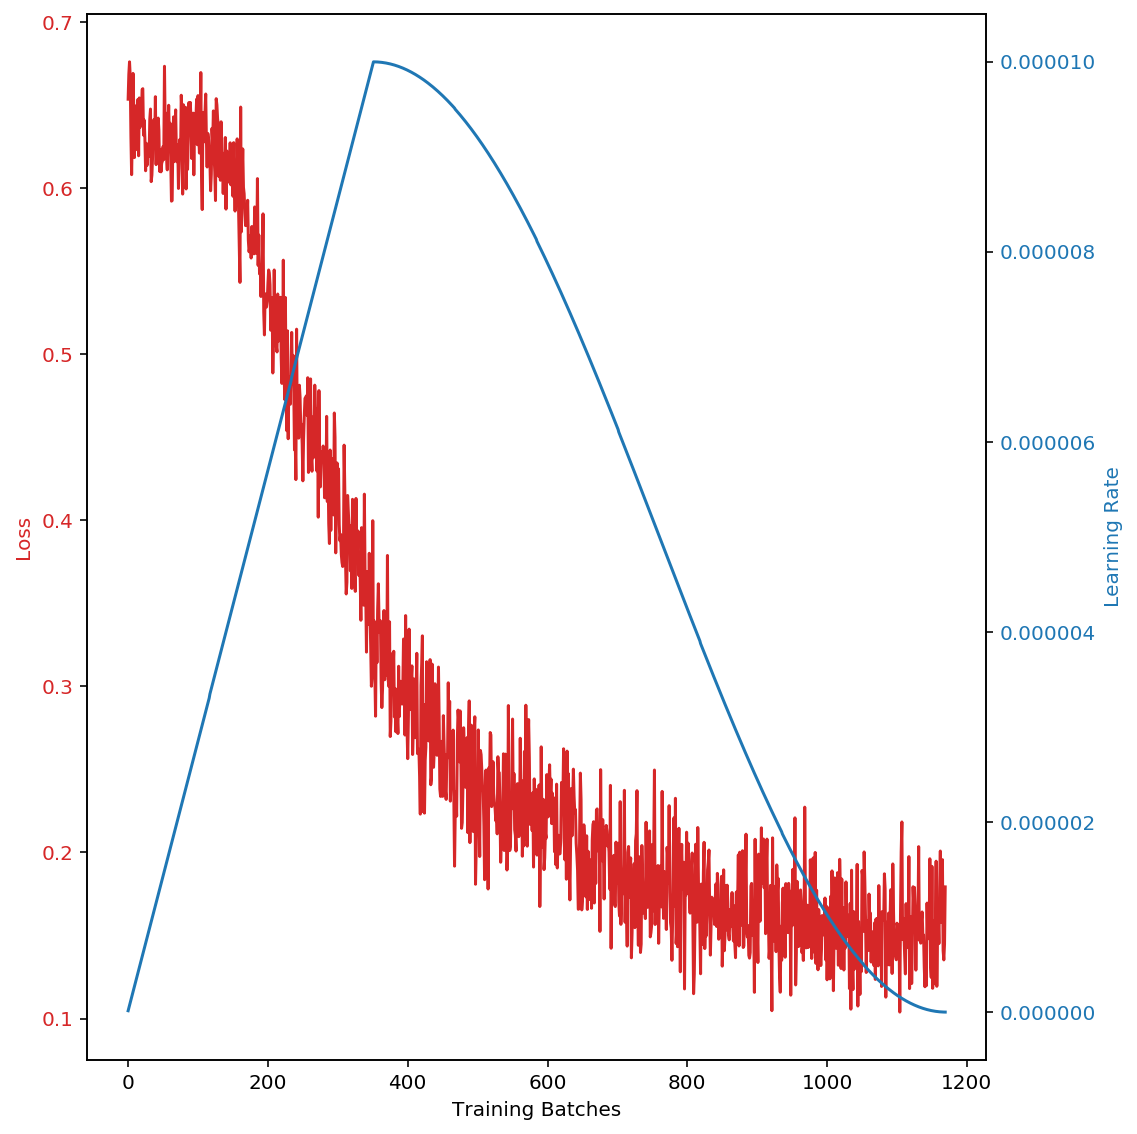

Proba       Preds    
           min   max   min max
Labels                        
0      -13.312 1.723     0   1
1        1.047 1.930     1   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,-2.904,"[4.25, -2.904296875]",0,0,-2.168,"[3.78515625, -2.16796875]",0,0,-5.734,"[6.50390625, -5.734375]",0,0
1,1.656,"[-1.3046875, 1.65625]",1,1,1.721,"[-1.615234375, 1.720703125]",1,1,1.553,"[-1.5087890625, 1.552734375]",1,1
2,-0.658,"[0.57080078125, -0.658203125]",0,0,1.460,"[-1.1416015625, 1.4599609375]",1,1,-3.594,"[4.85546875, -3.59375]",0,0
3,-8.570,"[9.2734375, -8.5703125]",0,0,1.246,"[-1.6171875, 1.24609375]",1,1,-0.903,"[0.8310546875, -0.9033203125]",0,0
4,1.670,"[-1.4404296875, 1.669921875]",1,1,-7.973,"[7.1015625, -7.97265625]",0,0,-1.164,"[2.37109375, -1.1640625]",0,0


scores =  {'map': '0.9957', 'acc': '0.9620', 'auc': '0.9985'}


([0.9957138139826127, 0.9620333333333333, 0.998473135],
 (array([1.        , 0.89774666]),
  array([0.94305, 1.     ]),
  array([0.97069041, 0.94611855]),
  array([20000, 10000])))

In [4]:
from torch.utils.data import Dataset, DataLoader
from mmf.common.sample import Sample, SampleList
import random

from facebook_hateful_memes_detector.preprocessing import NegativeSamplingDataset

from torchtext.data import Dataset, TabularDataset, Field
dataset = Dataset(texts, [("text", Field())])
ns_dataset = NegativeSamplingDataset(dataset, 2)


class BertDualClassifier(torch.nn.Module):
    def __init__(self, model, n_tokens_in, word_masking_proba):
        super().__init__()
        self.model = model
        if type(self.model) == str:
            self.model = AutoModel.from_pretrained(self.model)
            self.tokenizer = AutoTokenizer.from_pretrained(model)
            
        self.classifier = nn.Sequential(nn.Linear(768 * 2, 256), nn.LeakyReLU(), nn.Linear(256, 2))
        self.loss = nn.CrossEntropyLoss()
        self.no_grad = True
        self.n_tokens_in = n_tokens_in
        self.word_masking_proba = word_masking_proba
        
    def tokenise(self, texts: List[str]):
        tokenizer = self.tokenizer
        n_tokens_in = self.n_tokens_in
        if self.training and self.word_masking_proba > 0:
            texts = [random_word_mask(t, tokenizer, self.word_masking_proba) for t in texts]
        converted_texts = tokenizer.batch_encode_plus(texts, add_special_tokens=True, pad_to_max_length=True, max_length=n_tokens_in, truncation=True)
        input_ids, attention_mask = converted_texts["input_ids"], converted_texts["attention_mask"]
        return torch.tensor(input_ids).to(get_device()), torch.tensor(attention_mask).to(get_device())
        
    def forward(self, texts):
        inp1 = texts[0]
        inp2 = texts[1]
        labels = texts[2].to(get_device())
        
        input_ids_1, attention_mask_1 = self.tokenise(inp1)
        input_ids_1, attention_mask_1 = input_ids_1.to(get_device()), attention_mask_1.to(get_device())
        input_ids_2, attention_mask_2 = self.tokenise(inp2)
        input_ids_2, attention_mask_2 = input_ids_2.to(get_device()), attention_mask_2.to(get_device())
        
        outputs_1 = self.model(input_ids_1, attention_mask=attention_mask_1)
        outputs_2 = self.model(input_ids_2, attention_mask=attention_mask_2)
        pooled_output_states_1 = outputs_1[1]
        pooled_output_states_2 = outputs_2[1]
        
        pooled_output = torch.cat([pooled_output_states_1, pooled_output_states_2], 1)
        logits = self.classifier(pooled_output)
        loss = self.loss(logits, labels.long())
        logits = logits.type(torch.float)
        return logits,0,0, loss

model_name = output_model + "-cor"

adamw = torch.optim.AdamW
adamw_params = dict(lr=1e-4, betas=(0.9, 0.99), eps=1e-08, weight_decay=1e-4)
optimizer_class = adamw
optimizer_params = adamw_params
scheduler_init_fn = get_cosine_schedule_with_warmup()


epochs = 20
batch_size = 128
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
    }
}

model_fn = model_builder(BertDualClassifier,
                         dict(model=model_name, n_tokens_in=96, word_masking_proba=0.15),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer_class,
                         optimiser_params=optimizer_params)


# 0.13393
# 0.087709

model, optimizer = model_fn()
indices = torch.randperm(len(ns_dataset))
indices_small_start = int(0.5 * len(ns_dataset))
indices_small_end = int(1.0 * len(ns_dataset))
print(indices_small_start, indices_small_end)

ns_dataset_sm_train = torch.utils.data.Subset(ns_dataset, indices[:indices_small_start])
ns_dataset_sm_test = torch.utils.data.Subset(ns_dataset, indices[indices_small_start: indices_small_end])

train_losses, learning_rates = train(model, optimizer, scheduler_init_fn, batch_size, epochs, ns_dataset,
                                     model_call_back=None, accumulation_steps=2, plot=True,
                                     collate_fn=None,
                                     sampling_policy=None, class_weights=None)

validate(model, batch_size, ns_dataset, display_detail=True, collate_fn=None,)


lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "finetune": True,
            "lr": optimizer_params["lr"] / 10,
        },
    },
    "classifier": {
        "lr": optimizer_params["lr"],
    }
}

model.no_grad = False
batch_size = 128
epochs = 10
optimizer_class = torch.optim.AdamW
optimizer_params = dict(lr=1e-4, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-5)

_ = group_wise_finetune(model, lr_strategy)
params_conf, _ = group_wise_lr(model, lr_strategy)
optimizer = optimizer_class(params_conf, **optimizer_params)

train_losses, learning_rates = train(model, optimizer, scheduler_init_fn, batch_size, epochs, ns_dataset,
                                     model_call_back=None, accumulation_steps=2, plot=True,
                                     collate_fn=None,
                                     sampling_policy=None, class_weights=None)

validate(model, batch_size, ns_dataset, display_detail=True, collate_fn=None)

save(model.model, model.tokenizer, output_dir=output_model + "-nsp-dual")



# NSP Style Pretraining

Pick stored Model /home/ahemf/cache/distilbert-v2-nsp-dual Model Class =  <class 'transformers.modeling_roberta.RobertaModel'> Tokenizer Class =  <class 'transformers.tokenization_roberta.RobertaTokenizer'>
Autocast =  True Epochs =  10 Divisor = 1 Examples = 10000 Batch Size =  128
Training Samples =  10000 Weighted Sampling =  False Num Batches =  79 Accumulation steps =  1



Epoch =  1 Loss = 0.570438 LR = 0.00003333



Epoch =  2 Loss = 0.398001 LR = 0.00006667



Epoch =  3 Loss = 0.316229 LR = 0.00010000



Epoch =  4 Loss = 0.283721 LR = 0.00009505



Epoch =  5 Loss = 0.256816 LR = 0.00008117



Epoch =  6 Loss = 0.242405 LR = 0.00006113



Epoch =  7 Loss = 0.239233 LR = 0.00003887



Epoch =  8 Loss = 0.230494 LR = 0.00001883



Epoch =  9 Loss = 0.223810 LR = 0.00000495



Epoch =  10 Loss = 0.214804 LR = 0.00000000



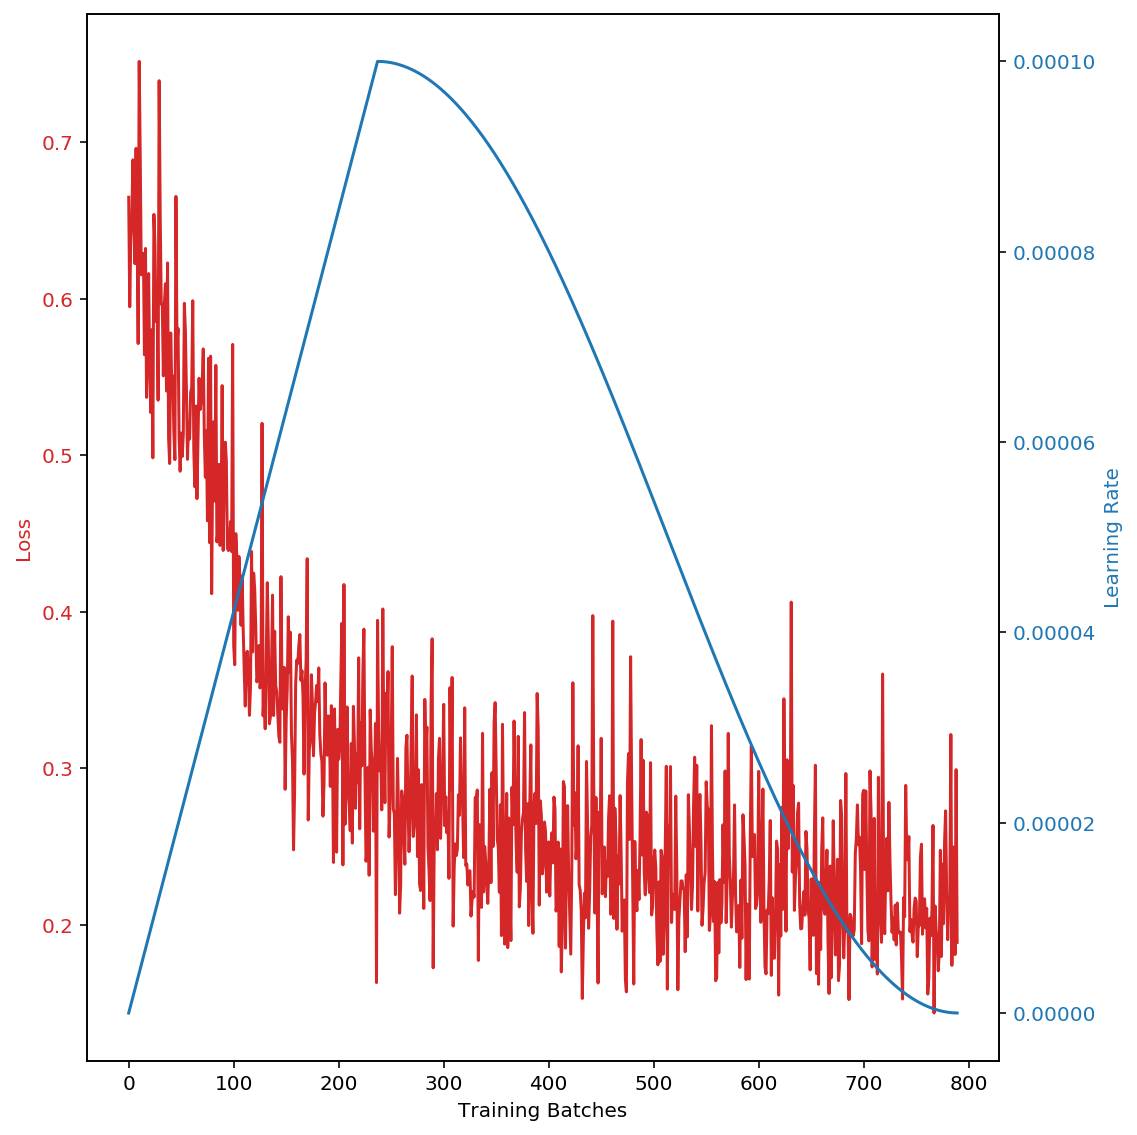

Proba       Preds    
         min   max   min max
Labels                      
0      0.016 0.923     0   1
1      0.043 0.966     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.870,"[0.13046462833881378, 0.8695353865623474]",1,1,0.947,"[0.05319225788116455, 0.9468077421188354]",1,1,0.038,"[0.9623112678527832, 0.03768862038850784]",0,0
1,0.045,"[0.9550292491912842, 0.04497073218226433]",0,0,0.873,"[0.12651026248931885, 0.8734896779060364]",1,1,0.165,"[0.8350270986557007, 0.1649729311466217]",0,0
2,0.092,"[0.9083160758018494, 0.09168387204408646]",0,0,0.727,"[0.2728602886199951, 0.7271396517753601]",1,1,0.050,"[0.9502289891242981, 0.0497710295021534]",0,0
3,0.853,"[0.14731773734092712, 0.8526822328567505]",1,1,0.031,"[0.9690858721733093, 0.030914094299077988]",0,0,0.071,"[0.9288665652275085, 0.07113342732191086]",0,0
4,0.098,"[0.9024052619934082, 0.09759464859962463]",0,0,0.046,"[0.953680694103241, 0.046319279819726944]",0,0,0.949,"[0.05064166337251663, 0.949358344078064]",1,1


scores =  {'map': '0.9822', 'acc': '0.9765', 'auc': '0.9935'}


([0.982242087289333, 0.9765, 0.9934629137127452],
 (array([0.98201124, 0.95438596]),
  array([0.98855634, 0.9296875 ]),
  array([0.98527292, 0.94187485]),
  array([7952, 2048])))

Autocast =  True Epochs =  10 Divisor = 1 Examples = 10000 Batch Size =  128
Training Samples =  10000 Weighted Sampling =  False Num Batches =  79 Accumulation steps =  1



Epoch =  1 Loss = 0.188378 LR = 0.00000333



Epoch =  2 Loss = 0.101063 LR = 0.00000667



Epoch =  3 Loss = 0.072520 LR = 0.00001000



Epoch =  4 Loss = 0.053362 LR = 0.00000950



Epoch =  5 Loss = 0.045329 LR = 0.00000812



Epoch =  6 Loss = 0.041308 LR = 0.00000611



Epoch =  7 Loss = 0.037806 LR = 0.00000389



Epoch =  8 Loss = 0.034964 LR = 0.00000188



Epoch =  9 Loss = 0.032816 LR = 0.00000050



Epoch =  10 Loss = 0.028724 LR = 0.00000000



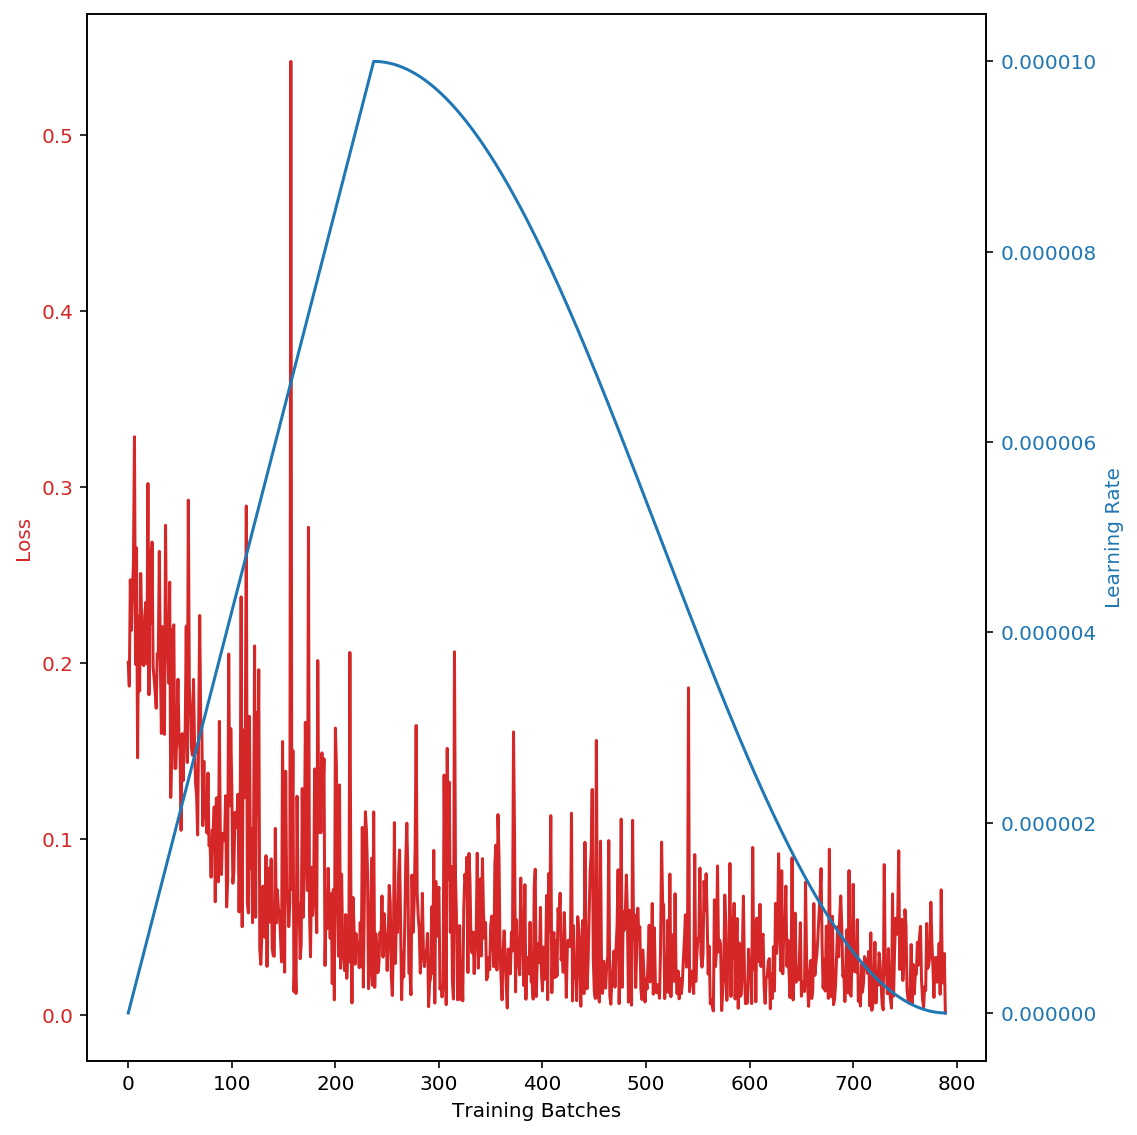

Proba       Preds    
         min   max   min max
Labels                      
0      0.000 0.997     0   1
1      0.002 1.000     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.000,"[0.9999935626983643, 6.354165179800475e-06]",0,0,0.000,"[0.9999257922172546, 7.424826617352664e-05]",0,0,1.000,"[1.2864780728705227e-05, 0.9999871253967285]",1,1
1,0.000,"[0.999993085861206, 6.847242275398457e-06]",0,0,0.000,"[0.9999818801879883, 1.8092528989654966e-05]",0,0,1.000,"[1.789019734133035e-05, 0.9999821186065674]",1,1
2,1.000,"[3.518148878356442e-05, 0.9999648332595825]",1,1,0.001,"[0.9988765716552734, 0.0011234022676944733]",0,0,0.999,"[0.0005725380033254623, 0.9994273781776428]",1,1
3,0.000,"[0.9999973773956299, 2.5843487492238637e-06]",0,0,0.000,"[0.9999616742134094, 3.8293459510896355e-05]",0,0,0.000,"[0.9999951124191284, 4.847935542784398e-06]",0,0
4,0.000,"[0.999990701675415, 9.26536085898988e-06]",0,0,0.000,"[0.9999697208404541, 3.0212242563720793e-05]",0,0,1.000,"[0.00023525195138063282, 0.9997648000717163]",1,1


scores =  {'map': '0.9993', 'acc': '0.9969', 'auc': '0.9998'}


([0.9993277283082226, 0.9969, 0.9998084653687219],
 (array([0.99737762, 0.99497992]),
  array([0.99874953, 0.98951573]),
  array([0.99806311, 0.9922403 ]),
  array([7997, 2003])))

In [5]:
from torch.utils.data import Dataset, DataLoader
from mmf.common.sample import Sample, SampleList
import random
class DiscriminatoryTextDataset(Dataset):
    def __init__(self, texts, process_text, separator_token):
        self.texts = list(texts)
        self.process_text = process_text
        self.separator_token = separator_token
        
    def __getitem__(self, item):
        process_text = self.process_text
        text = self.texts[item]
        separator_token = self.separator_token
        if random.random() < 0.2:
            if random.random() < 0.3:
                return Sample({"text": text+separator_token+process_text(text), "label": 1})
            elif random.random() < 0.7:
                return Sample({"text": process_text(text)+separator_token+text, "label": 1})
            else:
                return Sample({"text": process_text(text)+separator_token+process_text(text), "label": 1})
        else:
            rt = random.sample(self.texts, 1)[0]
            if random.random() < 0.3:
                return Sample({"text": text+separator_token+process_text(rt), "label": 0})
            elif random.random() < 0.7:
                return Sample({"text": process_text(text)+separator_token+rt, "label": 0})
            else:
                return Sample({"text": process_text(text)+separator_token+process_text(rt), "label": 0})
            
    
    def __len__(self):
        return len(self.texts)
    
model_name = output_model + "-nsp-dual" # "-augsim"

adamw = torch.optim.AdamW
adamw_params = dict(lr=1e-4, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-2)
optimizer_class = adamw
optimizer_params = adamw_params
scheduler_init_fn = get_cosine_schedule_with_warmup()

choice_probas = {
    "keyboard": 0.1,
    "char_substitute": 0.0,
    "char_insert": 0.1,
    "char_swap": 0.0,
    "ocr": 0.0,
    "char_delete": 0.1,
    "split": 0.2,
    "stopword_insert": 0.2,
    "word_join": 0.2,
    "word_cutout": 0.5,
    "text_rotate": 0.0,
    "sentence_shuffle": 0.0,
    "one_third_cut": 0.3,
    "half_cut": 0.1,
    "part_select": 0.3
}

preprocess_text = TextAugment([0.0, 0.5, 0.5],
                                choice_probas,
                                fasttext_file="wiki-news-300d-1M-subword.bin")

dataset = DiscriminatoryTextDataset(texts, preprocess_text, f" {tokenizer.sep_token} ")


epochs = 10
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
    }
}

model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.0,
                              dropout=0.0,
                              word_masking_proba=0.15,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=0,
                              n_encoders=0,
                              n_decoders=0,
                              n_tokens_in=96*2,
                              n_tokens_out=48,
                              featurizer="transformer",
                              classification_head="head_ensemble",
                              model=model_name,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer_class,
                         optimiser_params=optimizer_params)


# 0.13393
# 0.087709

model, optimizer = model_fn()
train_losses, learning_rates = train(model, optimizer, scheduler_init_fn, batch_size, epochs, dataset,
                                     model_call_back=None, accumulation_steps=1, plot=True,
                                     sampling_policy=None, class_weights=None)

validate(model, batch_size, dataset, display_detail=True)

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "finetune": True,
            "lr": optimizer_params["lr"] / 10,
        },
    },
    "final_layer": {
        "lr": optimizer_params["lr"],
    }
}
epochs = 10
optimizer_class = torch.optim.AdamW
optimizer_params = dict(lr=1e-4, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-4)

_ = group_wise_finetune(model, lr_strategy)
params_conf, _ = group_wise_lr(model, lr_strategy)
optimizer = optimizer_class(params_conf, **optimizer_params)

train_losses, learning_rates = train(model, optimizer, scheduler_init_fn, batch_size, epochs, dataset,
                                     model_call_back=None, accumulation_steps=1, plot=True,
                                     sampling_policy=None, class_weights=None)

validate(model, batch_size, dataset, display_detail=True)

save(model.model, model.tokenizer, output_dir=output_model + "-nsp")
